In [56]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import genextreme
from scipy.stats import genpareto
from scipy.optimize import minimize
from numpy.linalg import inv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [36]:
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


In [37]:
data.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [38]:
prices = data.Close

In [39]:
prices

Ticker,AAPL
Date,
2015-01-02,24.261042
2015-01-05,23.577574
2015-01-06,23.579792
2015-01-07,23.910427
2015-01-08,24.829119
...,...
2024-12-24,257.286682
2024-12-26,258.103729
2024-12-27,254.685867


In [40]:
returns = np.log(prices / prices.shift(1)).dropna()

In [41]:
neg_returns = -returns

In [42]:
block_size = 30
blocks = neg_returns.groupby(np.arange(len(neg_returns)) // block_size).max()

In [43]:
# 5. Estimation des paramètres de la loi GEV
# scipy définit la GEV avec paramètre shape = -xi (attention au signe)
shape, loc, scale = genextreme.fit(blocks)

print(f"Paramètres estimés :")
print(f"xi (shape) = {-shape:.4f}")
print(f"mu (loc)   = {loc:.4f}")
print(f"sigma      = {scale:.4f}")

Paramètres estimés :
xi (shape) = 0.1086
mu (loc)   = 0.0262
sigma      = 0.0131


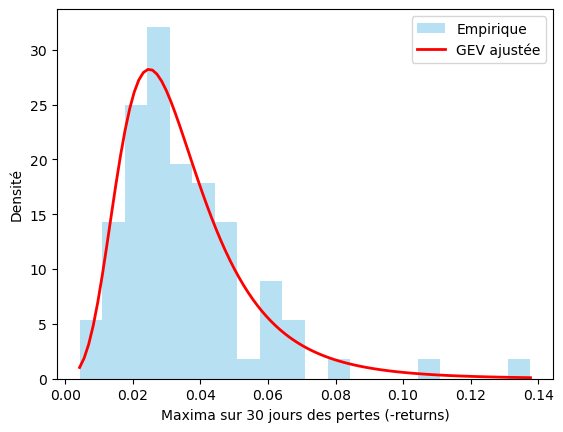

In [44]:
# 6. Vérification graphique
x = np.linspace(blocks.min(), blocks.max(), 100)
pdf_fitted = genextreme.pdf(x, shape, loc=loc, scale=scale)

plt.hist(blocks, bins=20, density=True, alpha=0.6, color="skyblue", label="Empirique")
plt.plot(x, pdf_fitted, "r-", lw=2, label="GEV ajustée")
plt.xlabel("Maxima sur 30 jours des pertes (-returns)")
plt.ylabel("Densité")
plt.legend()
plt.show()

In [45]:
blocks = blocks.values  # en numpy array

# === Log-vraisemblance négative ===
def neg_loglik(params, data):
    c, loc, scale = params
    if scale <= 0:
        return np.inf
    return -np.sum(genextreme.logpdf(data, c, loc=loc, scale=scale))

# === Estimation MLE via minimize ===
init_params = [0.1, np.mean(blocks), np.std(blocks)]
res = minimize(neg_loglik, init_params, args=(blocks,), method="L-BFGS-B",
               bounds=[(-1, 1), (None, None), (1e-6, None)])

c_hat, loc_hat, scale_hat = res.x

# === Calcul de la Hessienne et de la matrice de variance-covariance ===
eps = np.sqrt(np.finfo(float).eps)

def hessian(f, params, data, eps=1e-5):
    n = len(params)
    hess = np.zeros((n, n))
    f0 = f(params, data)
    for i in range(n):
        for j in range(n):
            dp = np.zeros(n)
            dq = np.zeros(n)
            dp[i] = eps
            dq[j] = eps
            fpp = f(params + dp + dq, data)
            fpm = f(params + dp - dq, data)
            fmp = f(params - dp + dq, data)
            fmm = f(params - dp - dq, data)
            hess[i, j] = (fpp - fpm - fmp + fmm) / (4 * eps**2)
    return hess

H = hessian(neg_loglik, res.x, blocks, eps)
cov_matrix = inv(H)
std_errors = np.sqrt(np.diag(cov_matrix))

print("=== Estimation MLE avec erreurs standard ===")
print(f"xi (shape) = {-c_hat:.4f} ± {std_errors[0]:.4f}")
print(f"mu (loc)   = {loc_hat:.4f} ± {std_errors[1]:.4f}")
print(f"sigma      = {scale_hat:.4f} ± {std_errors[2]:.4f}")


=== Estimation MLE avec erreurs standard ===
xi (shape) = -0.1000 ± 0.0592
mu (loc)   = 0.0354 ± 0.0031
sigma      = 0.0205 ± 0.0032


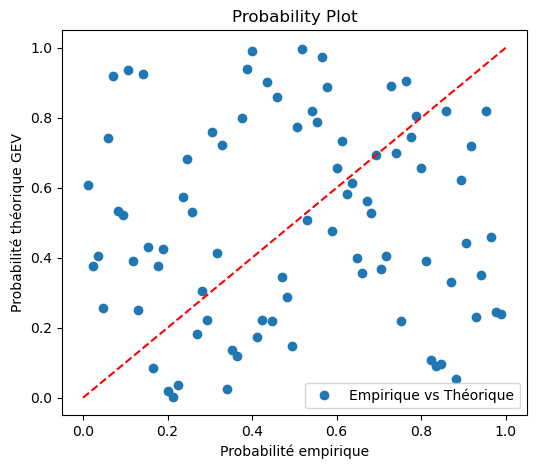

In [46]:
# === 1. Probability Plot ===
ecdf = np.arange(1, len(blocks)+1) / (len(blocks)+1)
sorted_data = np.sort(blocks)
gev_cdf = genextreme.cdf(sorted_data, shape, loc=loc, scale=scale)

plt.figure(figsize=(6,5))
plt.plot(ecdf, gev_cdf, "o", label="Empirique vs Théorique")
plt.plot([0,1], [0,1], "r--")
plt.xlabel("Probabilité empirique")
plt.ylabel("Probabilité théorique GEV")
plt.title("Probability Plot")
plt.legend()
plt.show()

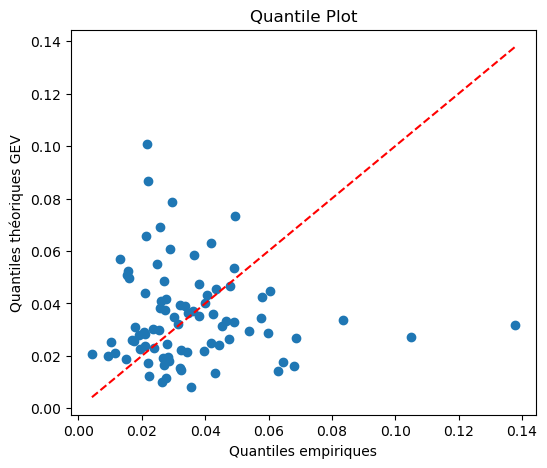

In [47]:
# === 2. Quantile Plot ===
emp_quantiles = sorted_data
theo_quantiles = genextreme.ppf(ecdf, shape, loc=loc, scale=scale)

plt.figure(figsize=(6,5))
plt.plot(emp_quantiles, theo_quantiles, "o")
plt.plot([emp_quantiles.min(), emp_quantiles.max()],
         [emp_quantiles.min(), emp_quantiles.max()], "r--")
plt.xlabel("Quantiles empiriques")
plt.ylabel("Quantiles théoriques GEV")
plt.title("Quantile Plot")
plt.show()

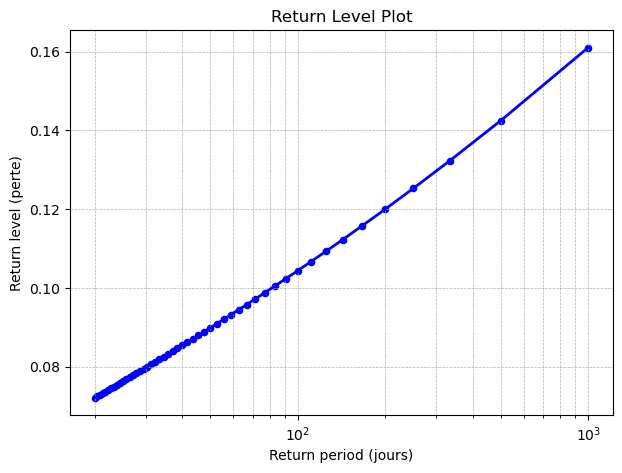

In [48]:
# === 3. Return Level Plot ===
# Return period T = 1/(1-p) -> niveau associé à probabilité p
probs = np.linspace(0.95, 0.999, 50)
return_periods = 1 / (1 - probs)
return_levels = genextreme.ppf(probs, shape, loc=loc, scale=scale)

plt.figure(figsize=(7,5))
plt.plot(return_periods, return_levels, "b-", lw=2)
plt.scatter(return_periods, return_levels, color="blue", s=20)
plt.xscale("log")
plt.xlabel("Return period (jours)")
plt.ylabel("Return level (perte)")
plt.title("Return Level Plot")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

In [60]:
## Visualisation de la GPD
data = yf.download("^FCHI", start="2010-01-01", end="2025-01-01")
returns = data['Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

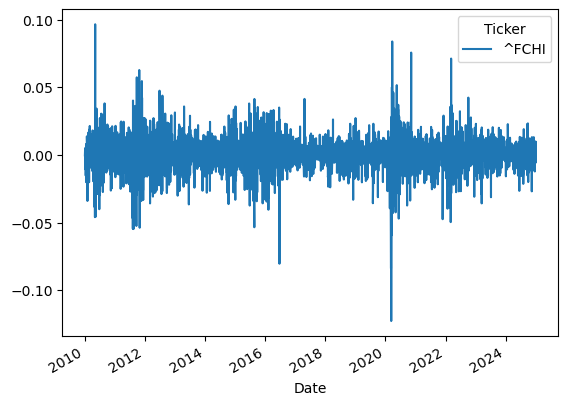

In [66]:
returns.plot()

array([[<Axes: title={'center': '^FCHI'}>]], dtype=object)

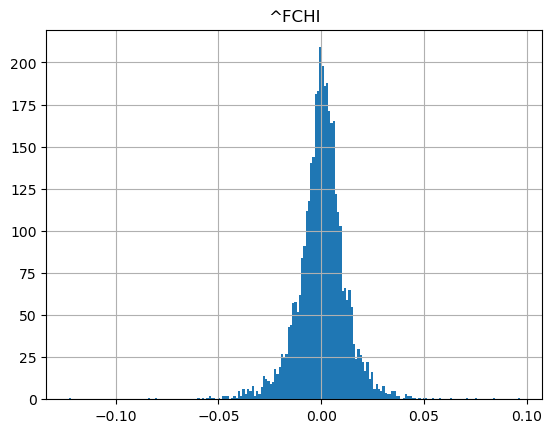

In [69]:
returns.hist(bins=200)

In [54]:
thresholds = [0.95, 0.975, 0.99]
u_values = [returns.quantile(q) for q in thresholds]
print(u_values)

[Ticker
^FCHI    0.018735
Name: 0.95, dtype: float64, Ticker
^FCHI    0.024038
Name: 0.975, dtype: float64, Ticker
^FCHI    0.032573
Name: 0.99, dtype: float64]


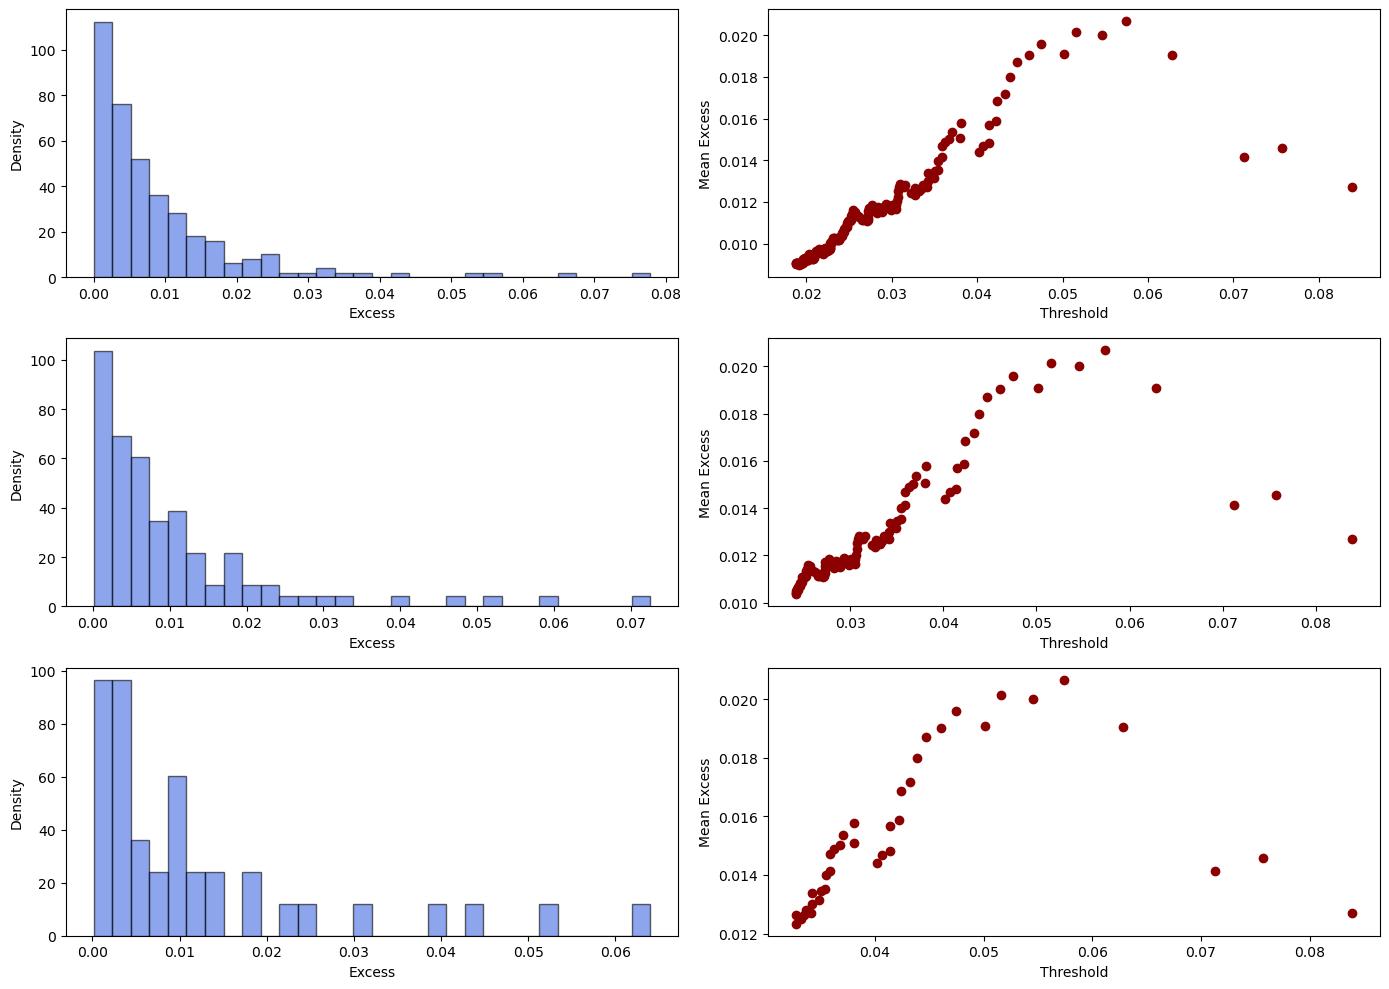

In [55]:
fig, axes = plt.subplots(len(u_values), 2, figsize=(14, 10))

for i, u in enumerate(u_values):
    exceedances = returns[returns > u] - u

    # Histogramme des excès
    axes[i, 0].hist(exceedances, bins=30, density=True, alpha=0.6, color="royalblue", edgecolor="black")
    #axes[i, 0].set_title(f"Excès au-dessus du seuil u={u:.4f}")
    axes[i, 0].set_xlabel("Excess")
    axes[i, 0].set_ylabel("Density")

    # Mean Residual Life (MRL) plot
    sorted_data = np.sort(returns[returns > u])
    mean_excess = [np.mean(sorted_data[sorted_data > t] - t) for t in sorted_data[:-10]]

    axes[i, 1].plot(sorted_data[:-10], mean_excess, marker="o", linestyle="", color="darkred")
    #axes[i, 1].set_title(f"Mean Residual Life Plot (u={u:.4f})")
    axes[i, 1].set_xlabel("Threshold")
    axes[i, 1].set_ylabel("Mean Excess")

plt.tight_layout()
plt.show()

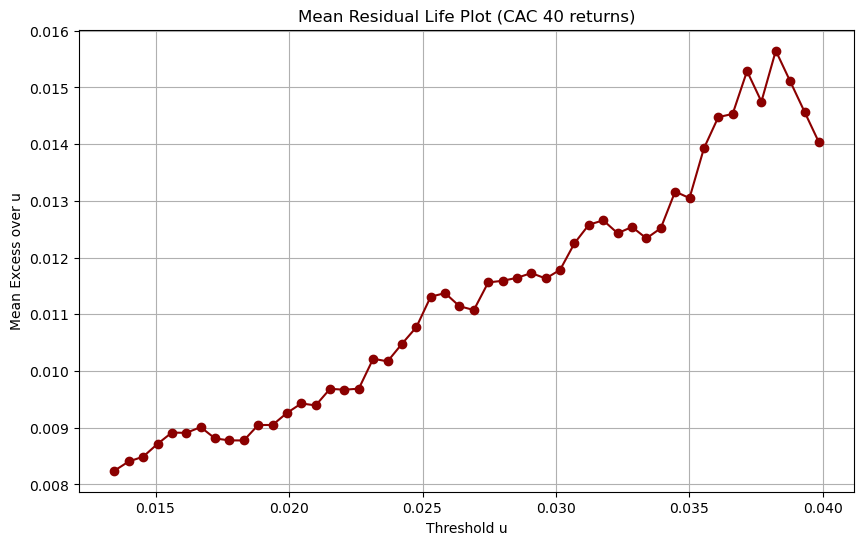

In [52]:
u_grid = np.linspace(returns.quantile(0.90), returns.quantile(0.995), 50)

mean_excess = []
for u in u_grid:
    exceedances = returns[returns > u] - u
    if len(exceedances) > 0:
        mean_excess.append(exceedances.mean())
    else:
        mean_excess.append(np.nan)

# Plot du Mean Residual Life (MRL)
plt.figure(figsize=(10,6))
plt.plot(u_grid, mean_excess, marker="o", linestyle="-", color="darkred")
plt.title("Mean Residual Life Plot (CAC 40 returns)")
plt.xlabel("Threshold u")
plt.ylabel("Mean Excess over u")
plt.grid(True)
plt.show()

In [85]:
# Seuils à tester
thresholds = [0.01, 0.02]

# Paramètres du bootstrap pour l'erreur standard
B = 200

# Liste pour stocker les résultats
results = []

for u in thresholds:
    exceedances = (returns[returns > u] - u).dropna().to_numpy().ravel()
    if len(exceedances) > 10:
        # Fit GPD sur les excès
        xi_hat, loc_hat, sigma_hat = genpareto.fit(exceedances, floc=0)
        
        # Bootstrap pour estimer l'écart-type
        xi_boot = []
        sigma_boot = []
        for _ in range(B):
            sample = np.random.choice(exceedances, size=len(exceedances), replace=True)
            try:
                xi_b, loc_b, sigma_b = genpareto.fit(sample, floc=0)
                xi_boot.append(xi_b)
                sigma_boot.append(sigma_b)
            except:
                continue
        xi_se = np.std(xi_boot)
        sigma_se = np.std(sigma_boot)
        
        results.append({
            "Threshold": u,
            "Parameter": "σu",
            "Estimate": sigma_hat,
            "Std Error": sigma_se
        })
        results.append({
            "Threshold": u,
            "Parameter": "ξ",
            "Estimate": xi_hat,
            "Std Error": xi_se
        })

# Convertir en DataFrame
df_results = pd.DataFrame(results)
print(df_results)


   Threshold Parameter  Estimate  Std Error
0       0.01        σu  0.007484   0.000421
1       0.01         ξ  0.095074   0.042953
2       0.02        σu  0.007242   0.000813
3       0.02         ξ  0.218643   0.087661


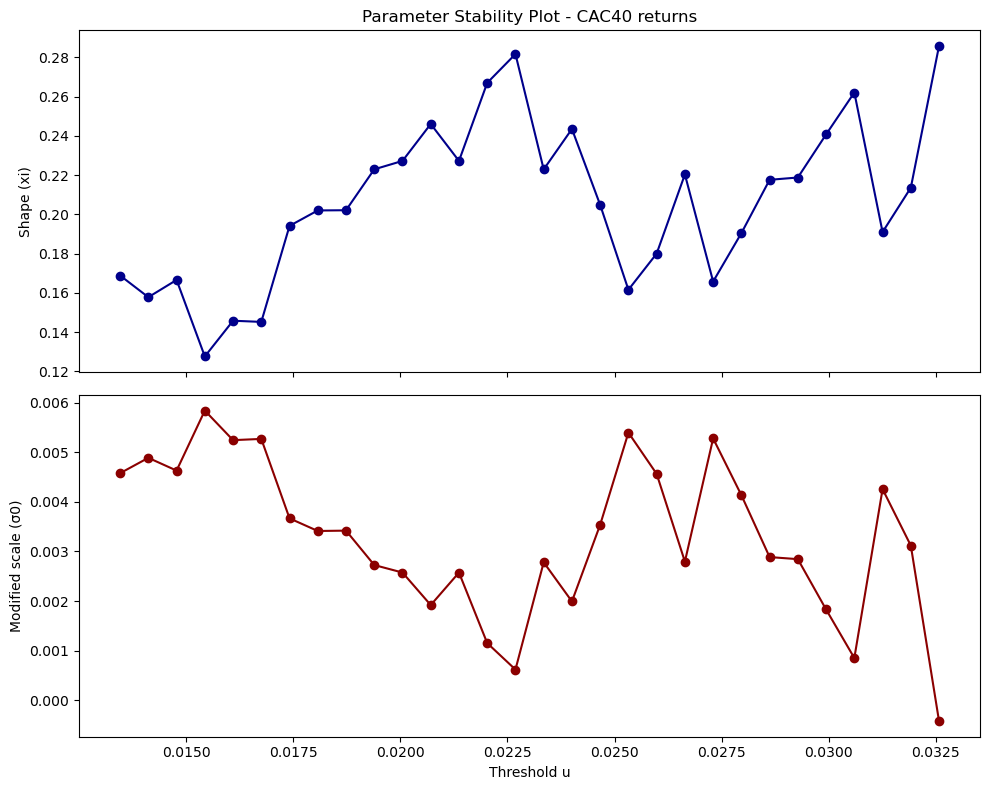

In [86]:
u_grid = np.linspace(returns.quantile(0.90), returns.quantile(0.99), 30)

xi_estimates = []
sigma0_estimates = []

for u in u_grid:
    exceedances = (returns[returns > u] - u).dropna()  # <-- correction ici
    if len(exceedances) > 10:  # éviter fit sur trop peu de points
        # Fit de la GPD sur les excès
        params = genpareto.fit(exceedances, floc=0)  # on fixe loc=0
        xi, loc, sigma = params
        sigma0 = sigma - xi * u
        xi_estimates.append(xi)
        sigma0_estimates.append(sigma0)
    else:
        xi_estimates.append(np.nan)
        sigma0_estimates.append(np.nan)

# Tracer la stabilité des paramètres
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax[0].plot(u_grid, xi_estimates, marker="o", color="darkblue")
ax[0].set_ylabel("Shape (xi)")
ax[0].set_title("Parameter Stability Plot - CAC40 returns")

ax[1].plot(u_grid, sigma0_estimates, marker="o", color="darkred")
ax[1].set_xlabel("Threshold u")
ax[1].set_ylabel("Modified scale (σ0)")

plt.tight_layout()
plt.show()

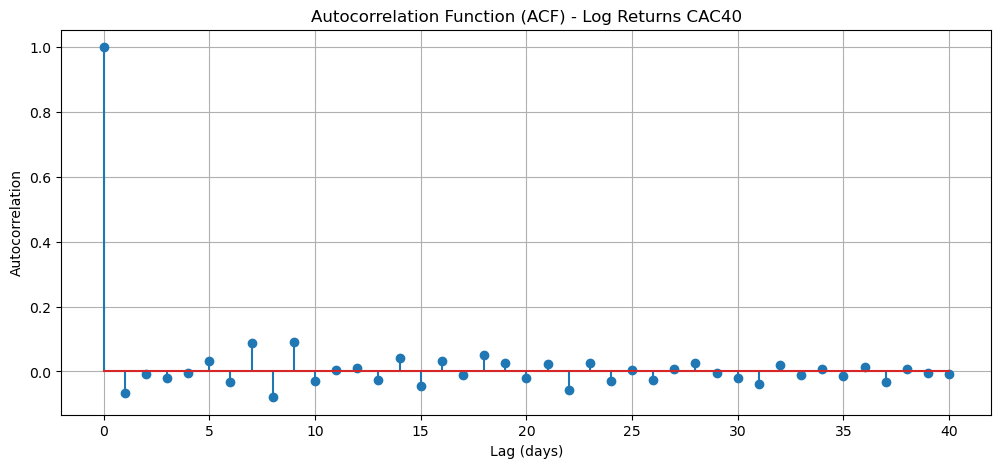

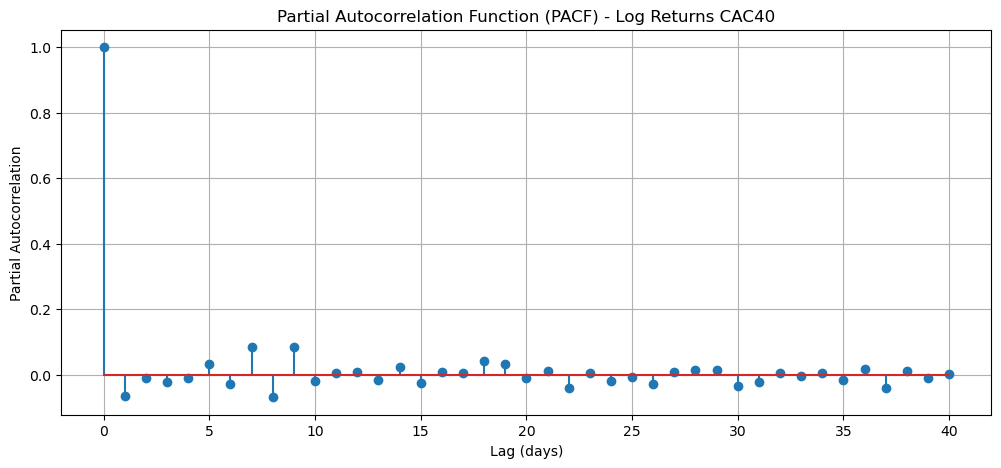

In [90]:
from statsmodels.tsa.stattools import acf, pacf


log_returns = np.log(prices / prices.shift(1)).dropna()

# Paramètres
max_lag = 40  # nombre de jours de lag à afficher

# Calcul ACF
acf_vals = acf(log_returns, nlags=max_lag, fft=False)

# Calcul de la PACF
pacf_vals = pacf(log_returns, nlags=max_lag)

# Plot ACF
plt.figure(figsize=(12,5))
plt.stem(range(max_lag+1), acf_vals)  # <-- suppression de use_line_collection
plt.title("Autocorrelation Function (ACF) - Log Returns CAC40")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12,5))
plt.stem(range(max_lag+1), pacf_vals)  # <-- suppression de use_line_collection
plt.title("Partial Autocorrelation Function (PACF) - Log Returns CAC40")
plt.xlabel("Lag (days)")
plt.ylabel("Partial Autocorrelation")
plt.grid(True)
plt.show()

In [92]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(returns, lags=10, return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
1    0.109187   0.741072
2    0.109367   0.946785
3    0.408137   0.938556
4    4.151755   0.385858
5    4.601601   0.466406
6    7.190326   0.303604
7   14.136277   0.048810
8   18.560185   0.017397
9   18.710013   0.027775
10  20.359497   0.026030
